In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import mpld3
import seaborn as sn
import numpy as np
import datetime as dt
import os
import time
import osgeo.osr as osr
import osgeo.gdal as gdal
from netCDF4 import Dataset
from dateutil import relativedelta
from mpl_toolkits.basemap import Basemap
sn.set_context('notebook')

# ICP Waters climate data processing

Heleen would like historic climate data for the sites involved in the updated TOC trends analysis (see e-mail received 07/02/2017 at 13.33 for details).

I have downloaded 0.5 degree resolution global gridded data with a monthly time step from the Climate Research Unit (CRU; dataset details [here](https://crudata.uea.ac.uk/cru/data/hrg/)), together with a 0.5 degree elevation datasets (available [here](http://www.temis.nl/data/topo/dem2grid.html) and [here](http://research.jisao.washington.edu/data_sets/elevation/)). The aim of this notebook is as follows:

 * Extract latitude/longitude co-ordinates and elevations from RESA2 for all the stations involved in the updated trends analysis. The list of sites to use is here:
 
   C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015\Results\trends_sites_oct_2016.xlsx <br><br>

 * Extract the grid cell elevations for each site from the elevation dataset. <br><br>
 
 * For the periods 1990 to 2012, 1990 to 2004 and 1998 to 2012, calculate the following summary statistics for both average temperature (`tmp`) and precipitation (`pre`): <br><br>
 
   * Average **annual** temperature and precipitation for the period of interest <br><br>
   * Average **summer (JJA)** temperature and precipitation for the period of interest <br><br>
   * Average **summer (JAS)** temperature and precipitation for the period of interest <br><br>
   * Average **September** temperature and precipitation for the period of interest <br><br>
   * Trends in the above 8 quantities over the duration of the period of interest, calculated using the Theil-Sen estimator. <br><br>
   * Trend significance for the above 8 quantities estimated using the Mann-Kendall method
 
 Note that the mean temperature estimates should all be corrected for the difference between pixel elevation and actual site elevation according to the **lapse rate**. The actual lapse rate is highly variable, but Heleen would like to use a value of 0.6C/100m (see e-mail received 23/01/2017 at 11.49).
 
## 1. Site data

The `readme` sheet of *trends_sites_oct_2016.xlsx* lists the RESA2 projects agreed with Heleen for inclusion in the updated trends analysis. I have extracted site data (co-ordinates and elevations) for all the sites associated with these projects. There are 609 sites in total, including some Swedish sites with no data. I'll ignore this issue for now and simply extract the climate data for the whole lot.

Three of the Norwegian sites in the database have only local (UTM Zone 33) co-ordinates. I've corrected this by manually converting the co-ordinates [here](http://home.hiwaay.net/~taylorc/toolbox/geography/geoutm.html). In addition, a number of the sites do not have elevation information. **My code will ignore these sites**, but if we get elevations for them in the furture we can simply re-run this analysis.

The spreadsheet of site data is here:

C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015\CRU_Climate_Data\toc_trends_sites_for_climate.xlsx

In [2]:
# Read station data
in_xls = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
          r'\CRU_Climate_Data\toc_trends_sites_for_climate.xlsx')

stn_df = pd.read_excel(in_xls, sheetname='DATA')

# Drop sites without elevations
stn_df.dropna(how='any', inplace=True)
   
stn_df.head()

,stn_id,stn_code,stn_name,lat,lon,elev_m
0,23469,CA20,"Ontario,Lake373",49.740,-93.793,424.0
1,23459,CA08,"Quebec, Lac Laflamme",47.317,-71.117,777.0
2,23468,CA19,Ontario. Lake 305,49.689,-93.686,404.0
3,23455,CA04,"Ontario, Algoma Region, Turkey Lake",47.050,-84.408,372.0
4,23460,CA09,"Quebec, Lac Macleod",47.467,-70.973,975.0


## 2. Elevation data

### 2.1. Read gridded elevation data

We'll start by working with the 0.5 degree dataset from [here](http://research.jisao.washington.edu/data_sets/elevation/).

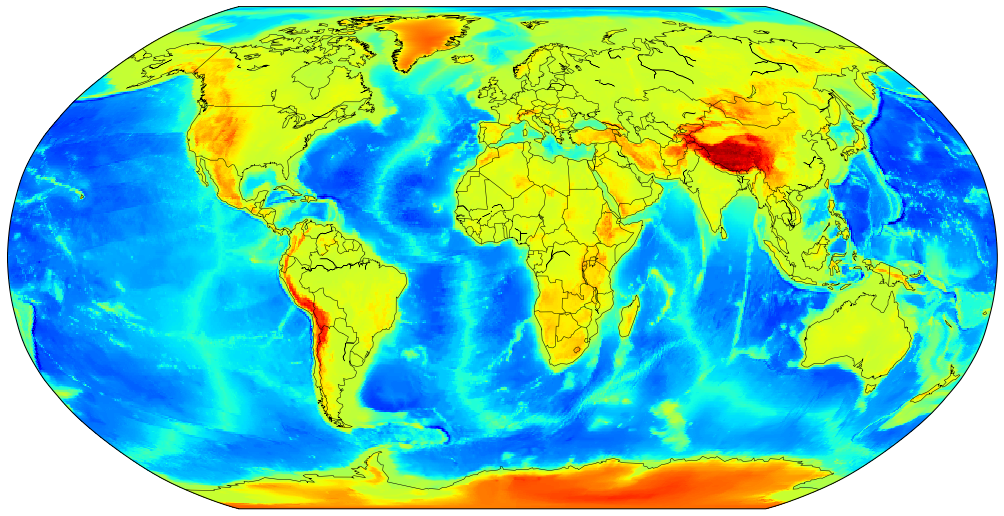

In [3]:
# Open elevation netCDF  
nc_file = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
           r'\CRU_Climate_Data\elevation\elev.0.5-deg.nc')
nc_data = Dataset(nc_file, 'r')

# Read lat and long grids from netCDF
lats = nc_data.variables['lat'][:]
lons = nc_data.variables['lon'][:]

# Read the elevation data
elev = nc_data.variables['data'][:]

# Plot using Robinson projection
fig = plt.figure(figsize=(18, 9))
m = Basemap(projection='robin', lon_0=0, resolution='c')

# Create grid of lon-lat coordinates 
xx, yy = np.meshgrid(lons, lats)

# Plot elev grid
im = m.pcolormesh(xx, yy, elev[0,:,:], latlon=True, cmap=plt.cm.jet) 

# Annotate
m.drawcountries()
m.drawcoastlines(linewidth=.5)

### 2.2. Pixel elevations for ICPW sites

In [ ]:
def convertXY(xy_source, inproj, outproj):
    # function to convert coordinates

    shape = xy_source[0,:,:].shape
    size = xy_source[0,:,:].size

    # the ct object takes and returns pairs of x,y, not 2d grids
    # so the the grid needs to be reshaped (flattened) and back.
    ct = osr.CoordinateTransformation(inproj, outproj)
    xy_target = np.array(ct.TransformPoints(xy_source.reshape(2, size).T))

    xx = xy_target[:,0].reshape(shape)
    yy = xy_target[:,1].reshape(shape)

    return xx, yy

# Open one of the netCDF files 
nc_file = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
           r'\CRU_Climate_Data\elevation\elev.0.5-deg.nc')
nc_data = Dataset(nc_file, 'r')

# Read lat and long grids from netCDF
lats = nc_data.variables['lat'][:]
lons = nc_data.variables['lon'][:]

# Read the elevation data
elev = nc_data.variables['data'][:]

# Create the projection original
inproj = osr.SpatialReference()
inproj.ImportFromEPSG(4326)

# Create the figure and basemap object
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='robin', lon_0=0, resolution='c')

# Get the target projection from the basemap object
outproj = osr.SpatialReference()
outproj.ImportFromProj4(m.proj4string)

# Create a grid of xy coordinates in the original projection
xy_source = np.array(np.meshgrid(lons, lats))

# Convert from source projection to basemap projection
xx, yy = convertXY(xy_source, inproj, outproj)

# Plot 
# Basemap doesn't like plotting across the dateline (?) so plot grid 
# in two parts

# Get max and min elev so that can huse the same colour scheme for each 
# hemisphere
el_min = elev.min()
el_max = elev.max()

# Plot E hemisphere
im1 = m.pcolormesh(xx[:,:360], yy[:,:360], elev[0,:,:360], 
                   cmap=plt.cm.jet, vmin=el_min, vmax=el_max) 

# Plot W hemisphere
im2 = m.pcolormesh(xx[:,360:], yy[:,360:], elev[0,:,360:], 
                   cmap=plt.cm.jet, vmin=el_min, vmax=el_max) 

# Annotate
m.drawcountries()
m.drawcoastlines(linewidth=.5)

In [ ]:
def geo_idx(dd, dd_array):
    """ Get array indices for specified lat/long co-ordinate.
        Adapted from here:
        http://stackoverflow.com/questions/33789379/
        netcdf-and-python-finding-the-closest-lon-lat-index-given-actual-lon-lat-values
    
    Args:
        dd       Lat or long value in decimal degrees
        dd_array Corresponding array of lat or long values from netCDF
    """
    geo_idx = (np.abs(dd_array - dd)).argmin()
    
    return geo_idx